In [46]:



# %%
import pandas as pd



# %% [markdown]
# ###  Install & Import Fairlearn
# 
# We’ll use Fairlearn’s **ThresholdOptimizer** to learn group-specific thresholds that equalize both TPR and FPR.

# %%
!pip install -q fairlearn

from fairlearn.postprocessing import ThresholdOptimizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report


# %%
# Extract gender series aligned to train/test splits
gender_train = df.loc[X_train.index, 'gender']   # or 'gender' if that's your column name
gender_test  = df.loc[X_test.index,  'gender']

# Quick sanity check
print("Training genders:", gender_train.value_counts().to_dict())
print("  Test   genders:", gender_test.value_counts().to_dict())

gender_train.value_counts().plot(kind="bar", title='Training Data')
plt.show()

gender_test.value_counts().plot(kind='bar', title='Test Data')
plt.show()

# %% [markdown]
# ### Step 1: Install & Import Fairlearn
# 
# We’ll use `ExponentiatedGradient` with `EqualizedOdds` to bake fairness into training.

# %%
!pip install -q fairlearn

from fairlearn.reductions import ExponentiatedGradient, EqualizedOdds
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from fairlearn.metrics import MetricFrame, true_positive_rate, false_positive_rate
import matplotlib.pyplot as plt
import seaborn as sns

# %% [markdown]
# ### Step 2: Prepare Sensitive Features DataFrames
# 
# Extract **gender** and **race** for your train/test splits so Fairlearn can enforce fairness across both.

# %%
# 1) isolate just gender
gender_train = df.loc[X_train.index, 'gender']
gender_test  = df.loc[X_test.index,  'gender']

# Quick preview
print("Training sensitive features:\n", gender_train.head())
print("\nTest sensitive features:\n",  gender_test.head())


# %% [markdown]
# ### Step 3: Train a Fairness‐Aware Model
# 
# Wrap a `LogisticRegression` in `ExponentiatedGradient` to enforce Equalized Odds.

# %%

# 2) define base estimator
base_est = LogisticRegression(max_iter=1000, random_state=42)

# 3) wrap in ExponentiatedGradient with EqualizedOdds on gender
mitigator = ExponentiatedGradient(
    estimator=base_est,
    constraints=EqualizedOdds(),
    eps=0.01              # tolerance for EO across gender groups
)

# 4) fit on training data + gender
mitigator.fit(
    X_train,
    y_train,
    sensitive_features=gender_train
)


# %% [markdown]
# ### Step 4: Evaluate Model
# 
# Check overall accuracy, classification report, then confirm TPR/FPR parity across (gender, race).

# %%

# 5) predict & evaluate
y_pred_fair = mitigator.predict(X_test)
print("Fair (gender-only) model accuracy:", accuracy_score(y_test, y_pred_fair))
print(classification_report(y_test, y_pred_fair))

# 6) compute TPR & FPR by gender
metric_frame = MetricFrame(
    metrics={'TPR': true_positive_rate, 'FPR': false_positive_rate},
    y_true=y_test,
    y_pred=y_pred_fair,
    sensitive_features=gender_test
)
print("\nEqualized Odds metrics by gender:")
print(metric_frame.by_group)


# %% [markdown]
# ### Step 5: Visualize TPR & FPR
# 
# Plot side‐by‐side bar charts to confirm the disparities have been reduced.

# %%

# 7) plot gender bars (no error bars)
gender_long = metric_frame.by_group.reset_index().melt(
    id_vars='gender',
    value_vars=['TPR','FPR'],
    var_name='Metric',
    value_name='Rate'
)

plt.figure(figsize=(6,4))
sns.barplot(
    data=gender_long,
    x='Metric',
    y='Rate',
    hue='gender',
    errorbar=None
)
plt.ylim(0,1)
plt.title("True Positive & False Positive Rates by Gender")
plt.ylabel("Rate")
plt.legend(title='Gender')
plt.show()

# %%
# Assuming `gender_summary` is your 1-row DataFrame from evaluate_equalized_odds
summary_table = pd.DataFrame({
    'attr': ['Gap', 'Ratio'],
    'TPR': [gender_summary.at[0, 'TPR_gap'],
            gender_summary.at[0, 'TPR_ratio']],
    'FPR': [gender_summary.at[0, 'FPR_gap'],
            gender_summary.at[0, 'FPR_ratio']]
})

# Display it nicely in Jupyter
summary_table.style.set_table_styles([
    {'selector': 'thx', 'props': [('text-align', 'center')]},
    {'selector': 'td', 'props': [('text-align', 'center')]}
])


# %% [markdown]
# ### Step 6: Save Your Production‐Ready Model
# 
# Serialize the fairness‐aware model for deployment, just like any other sklearn estimator.
# ```
# joblib.dump(mitigator, 'fair_prod_model_multigroup.joblib')
# print("✅ Model saved → fair_prod_model_multigroup.joblib")
# ```



# 🧠 Fairness in Machine Learning — Hands-on Workshop
## Welcome! In this workshop, you'll:
#### - Train a model to predict income
#### - Evaluate fairness across **gender**
#### - Apply a fairness mitigation technique (Equalized Odds)
## Let's get started!

# 📦 Install required packages (only run once)

In [9]:
%%capture
!pip install -U pip # Make sure pip is up to date
!pip install -q numpy pandas matplotlib scikit-learn seaborn fairlearn

# 📚 Step 1: Import Libraries

In [11]:
# Standard data manipulation tools
import pandas as pd
import numpy as np

# Plotting tools
import matplotlib.pyplot as plt
import seaborn as sns

# ML tools
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Fairness tools
from fairlearn.metrics import MetricFrame, true_positive_rate, false_positive_rate
from fairlearn.reductions import ExponentiatedGradient, EqualizedOdds

# 📥 Step 2: Load and Prepare the Data

In [14]:
# Load dataset
url = "https://raw.githubusercontent.com/saravrajavelu/Adult-Income-Analysis/refs/heads/master/adult.csv"

# Read the data from the url
df = pd.read_csv(url)

# Encode target label
df['income_higher_than_50k'] = df['income'].map({'<=50K':0, '>50K':1})
df = df.replace('?', np.nan) # This dataset uses '?' as a placeholder for missing data, let's use the best practices with np.nan

# Preview the cleaned data
df.head()
# Todo: Inspect the data and think about what each column means

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income,income_higher_than_50k
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K,0
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K,0
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K,1
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K,1
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K,0


# Step 3: Exploratory Data Analysis (EDA)


In [15]:
# ─── 3.1 CHECK SHAPE & TYPES ─────────────────────────────
print("Records, Features:", df.shape)
df.info()
# TODO: Note which columns are numeric vs object (categorical)

Records, Features: (48842, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   age                     48842 non-null  int64 
 1   workclass               46043 non-null  object
 2   fnlwgt                  48842 non-null  int64 
 3   education               48842 non-null  object
 4   educational-num         48842 non-null  int64 
 5   marital-status          48842 non-null  object
 6   occupation              46033 non-null  object
 7   relationship            48842 non-null  object
 8   race                    48842 non-null  object
 9   gender                  48842 non-null  object
 10  capital-gain            48842 non-null  int64 
 11  capital-loss            48842 non-null  int64 
 12  hours-per-week          48842 non-null  int64 
 13  native-country          47985 non-null  object
 14  income                 

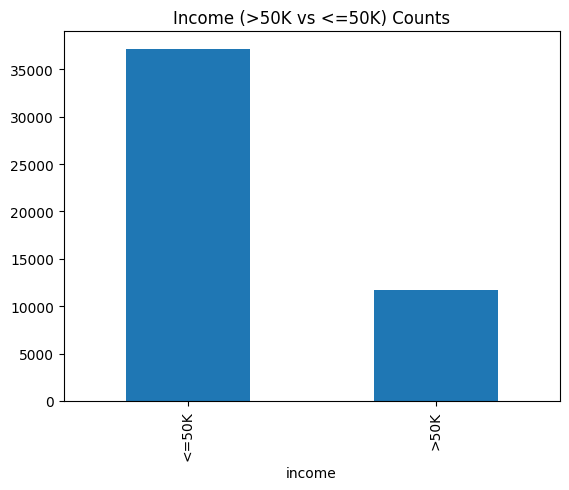

In [27]:
# ─── 3.2 TARGET DISTRIBUTION ────────────────────────────
df['income'].value_counts().plot(
    kind='bar', title='Income (>50K vs <=50K) Counts'
)
plt.show()
# TODO: What % earn >50K?
# JI_TODO: 
# - low recall (TPR) for the minority class — you miss high earners, which in a loan scenario = denied credit to creditworthy people
# - A model can get high overall accuracy (e.g., 75%) just by predicting <=50K for everyone — but that’s useless in practice.

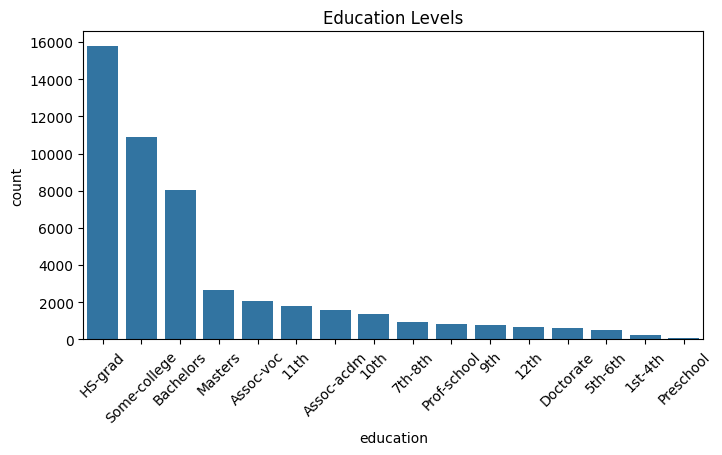

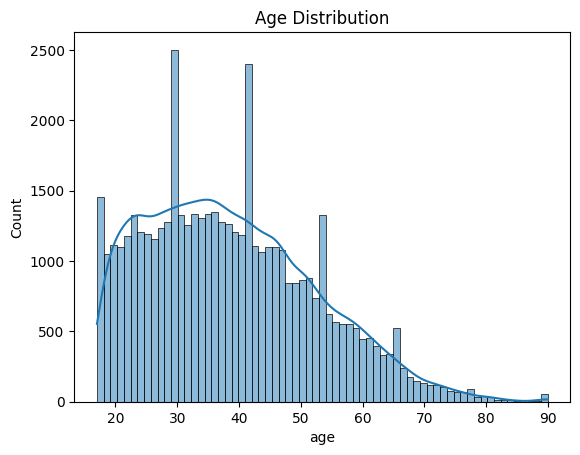

In [28]:
# ─── 2.3 FEATURE VISUALIZATIONS ─────────────────────────
# Categorical: education
plt.figure(figsize=(8,4))
sns.countplot(x='education', data=df,
              order=df['education'].value_counts().index)
plt.xticks(rotation=45)
plt.title("Education Levels")
plt.show()

# Numeric: age distribution
sns.histplot(df['age'], kde=True)
plt.title("Age Distribution")
plt.show()

# Correlation Matrix of Numeric Features
We often start by looking at how numeric features correlate with each other **and** with our target (`income`).  
High positive or negative correlations can hint at strong predictors or multicollinearity issues.


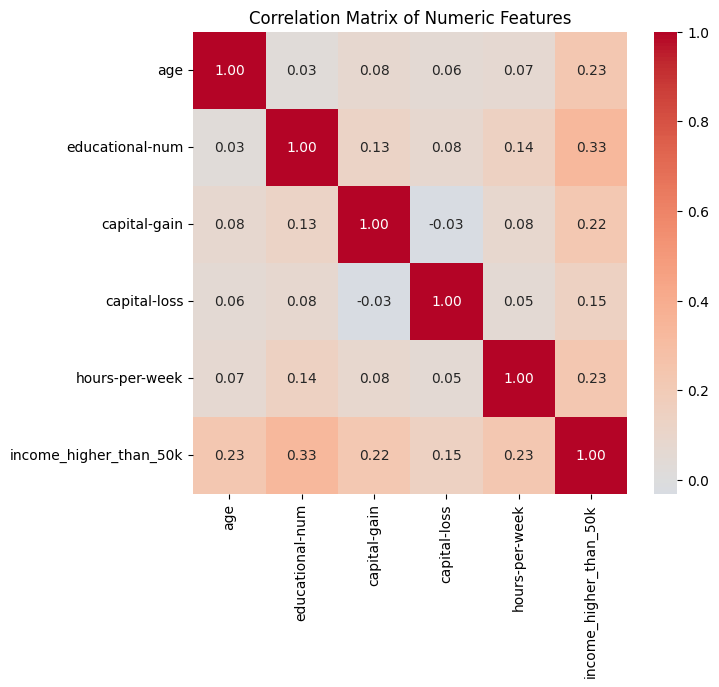

In [29]:
# Identify numeric columns + our binary target
numeric_cols = ['age', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']
corr_df = df[numeric_cols + ['income_higher_than_50k']].corr()

plt.figure(figsize=(7,6))
sns.heatmap(corr_df, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Correlation Matrix of Numeric Features")
plt.show()

## Income Proportions by Education Level
For a categorical feature, a **stacked bar chart** shows the proportion of each income class within each category.  
This reveals which education levels have higher fractions of >50K earners.


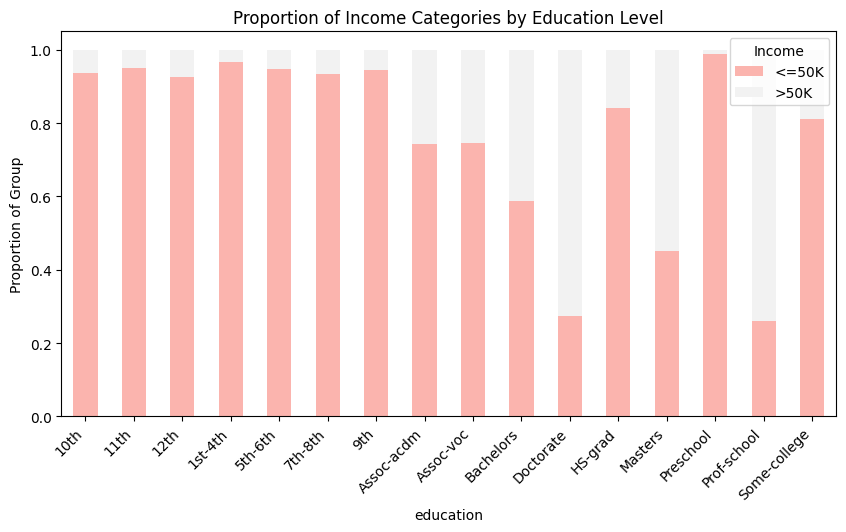

In [30]:
edu_prop = pd.crosstab(df['education'], df['income'], normalize='index')

edu_prop.plot(
    kind='bar',
    stacked=True,
    figsize=(10,5),
    colormap='Pastel1'
)
plt.title("Proportion of Income Categories by Education Level")
plt.ylabel("Proportion of Group")
plt.xticks(rotation=45, ha='right')
plt.legend(title='Income')
plt.show()

## Age vs Hours-per-Week
A scatterplot of **age** against **hours-per-week**, colored by income, can show whether high earners cluster in certain age or work-hour ranges.


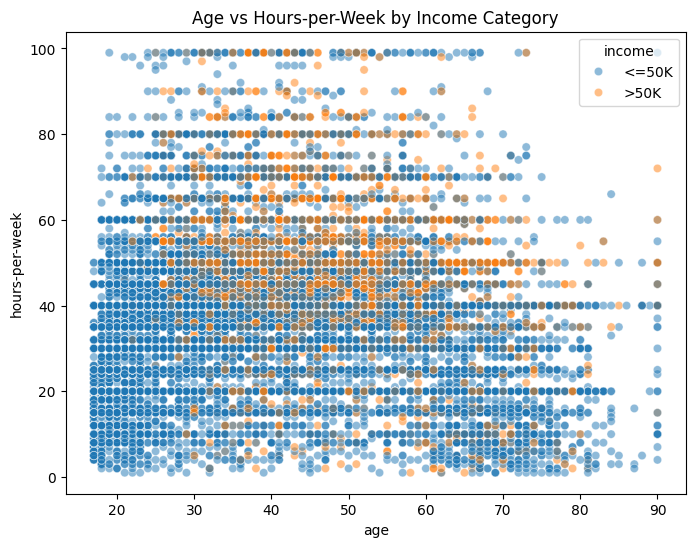

In [31]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    x='age', y='hours-per-week',
    hue='income', data=df, alpha=0.5
)
plt.title("Age vs Hours-per-Week by Income Category")
plt.show()


## Marital Status Distribution among >50K Earners
Pie charts can quickly show which marital statuses are most common among high earners.


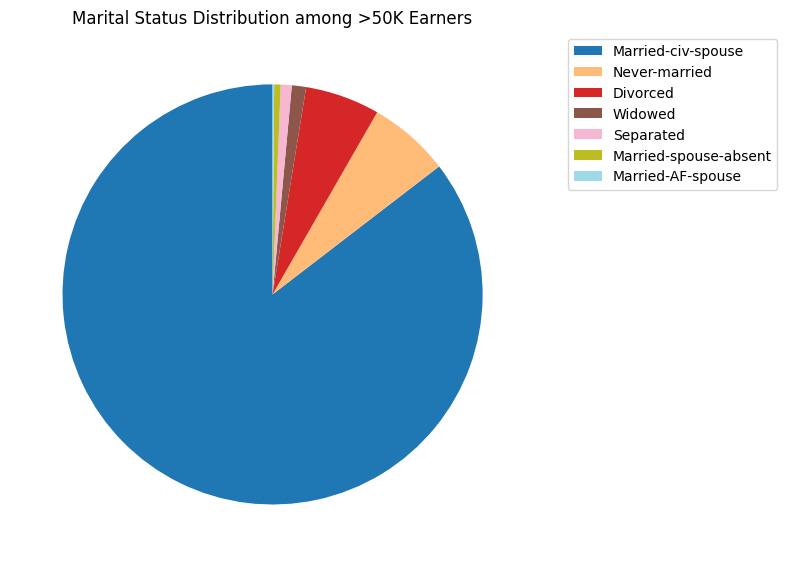

In [32]:
high_status = df[df['income_higher_than_50k']==1]['marital-status'].value_counts()

plt.figure(figsize=(8, 8))
high_status.plot(
    kind='pie',
    startangle=90,
    colormap='tab20',
    labels=None  # Hide labels on pie
)
plt.legend(labels=high_status.index, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel("")
plt.title("Marital Status Distribution among >50K Earners")
plt.tight_layout()
plt.show()



## Top 10 Occupations for >50K Earners
A horizontal bar chart of the most frequent occupations among high earners can highlight which roles are most associated with higher income.


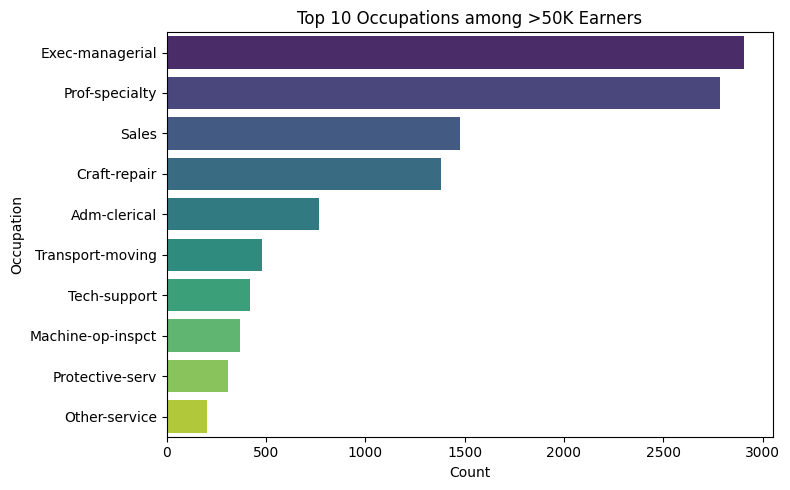

In [33]:
# Prepare data
top_occ = df[df['income'] == '>50K']['occupation'].value_counts().nlargest(10)
top_occ_df = top_occ.reset_index()
top_occ_df.columns = ['occupation', 'count']

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(
    data=top_occ_df,
    y='occupation',
    x='count',
    hue='occupation',      # required to use palette safely
    palette='viridis'
)
plt.title("Top 10 Occupations among >50K Earners")
plt.xlabel("Count")
plt.ylabel("Occupation")
plt.tight_layout()
plt.show()


<Axes: xlabel='occupation', ylabel='age'>

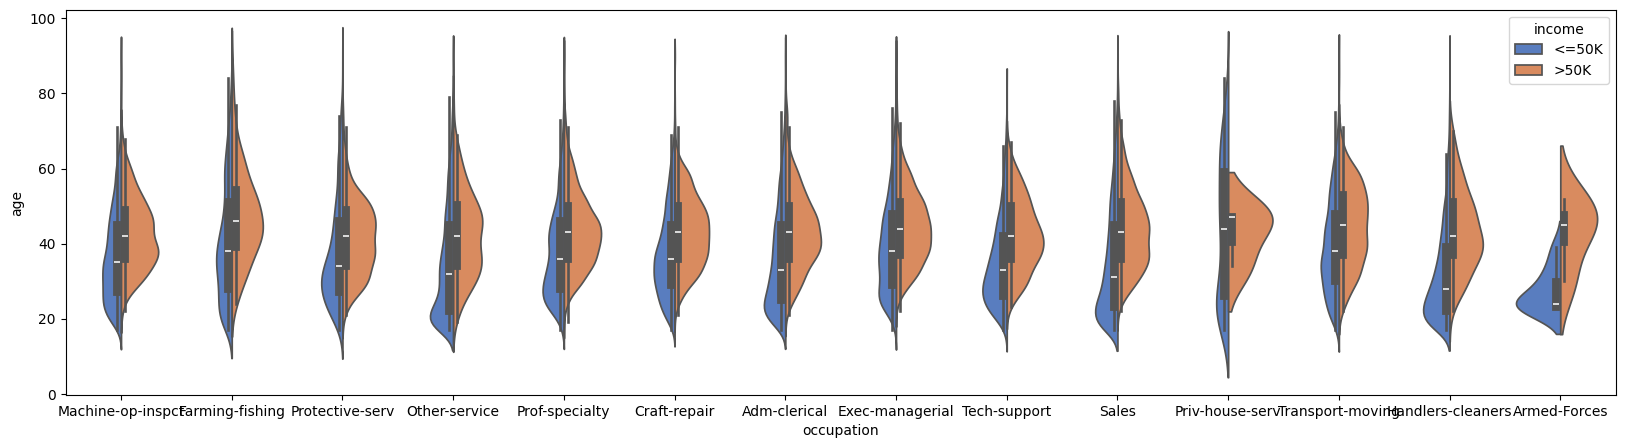

In [45]:
from matplotlib import pyplot
a4_dims = (20, 5)
fig, ax = pyplot.subplots(figsize=a4_dims)
ax = sns.violinplot(x="occupation", y="age", hue="income",
                    data=df, gridsize=100, palette="muted", split=True, saturation=0.75)
ax



## Why use?
 
- Correlation heatmap highlights which features move together—and how strongly they relate to the target.
- Boxplots and scatterplots help spot outliers and distribution differences between income groups.
- Stacked bars show category-level propensities.
- Pie and occupation charts give intuitive views of group makeup.


# Step 4: Data Preprocessing

In [34]:
# ─── 4.1 HANDLE MISSING VALUES ───────────────────────────
print((df.isna()).sum()) # Check how many and what values are missing
old_size = len(df)
print() # For spacing
print(f'Size of dataset = {len(df)}')
df = df.dropna()         # simple drop for workshop since missing data is not too big
# TODO: How many rows were removed?
print(f'Size of dataset after removing missing values {len(df)}')

age                          0
workclass                 2799
fnlwgt                       0
education                    0
educational-num              0
marital-status               0
occupation                2809
relationship                 0
race                         0
gender                       0
capital-gain                 0
capital-loss                 0
hours-per-week               0
native-country             857
income                       0
income_higher_than_50k       0
dtype: int64

Size of dataset = 48842
Size of dataset after removing missing values 45222


In [35]:
# ─── 4.2 ENCODE CATEGORICALS ────────────────────────────
# We use one-hot encoding instead of numeric labels because decision trees split data based on feature values. 
# If we assign numbers like `Private = 1`, `State-gov = 2`, it introduces a fake order (e.g., 2 > 1), which misleads the model.
# This is called One-hot encoding and it avoids this by creating separate 0/1 columns for each category, 
# letting the tree split cleanly on exact matches without assuming any order.
# It's more accurate and reliable for decision trees.

cat_cols = df.select_dtypes('object').columns.drop('income')
df_enc = pd.get_dummies(df, columns=cat_cols)
# TODO: Inspect df_enc.columns to see new dummy columns
# SPEAKER_TODO talk about this in terms of decision trees why this would be nice!
df_enc.columns
df_enc.head()

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,income,income_higher_than_50k,workclass_Federal-gov,workclass_Local-gov,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,25,226802,7,0,0,40,<=50K,0,False,False,...,False,False,False,False,False,False,False,True,False,False
1,38,89814,9,0,0,50,<=50K,0,False,False,...,False,False,False,False,False,False,False,True,False,False
2,28,336951,12,0,0,40,>50K,1,False,True,...,False,False,False,False,False,False,False,True,False,False
3,44,160323,10,7688,0,40,>50K,1,False,False,...,False,False,False,False,False,False,False,True,False,False
5,34,198693,6,0,0,30,<=50K,0,False,False,...,False,False,False,False,False,False,False,True,False,False


In [36]:
# ─── 4.3 BINARY TARGET & SCALING ────────────────────────
# Scale numeric features
from sklearn.preprocessing import StandardScaler
num_cols = ['age','fnlwgt','educational-num',
            'capital-gain','capital-loss','hours-per-week']
scaler = StandardScaler()
df_enc[num_cols] = scaler.fit_transform(df_enc[num_cols])


In [37]:
# ─── 3.4 TRAIN/TEST SPLIT ────────────────────────────────
X_labels = df_enc.drop('income', axis=1)
X = X_labels.drop('income_higher_than_50k', axis=1)
y = df_enc['income_higher_than_50k']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
y

0        0
1        0
2        1
3        1
5        0
        ..
48837    0
48838    1
48839    0
48840    0
48841    1
Name: income_higher_than_50k, Length: 45222, dtype: int64

# Step 5: Model Training & Evaluation


In [38]:
# ─── 5.1 TRAIN MODEL ─────────────────────────────────────
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
# TODO: This may take ~30 seconds – watch for convergence warnings.

LogisticRegression(max_iter=1000)

In [39]:
# ─── 5.2 PREDICT & ACCURACY ──────────────────────────────
y_pred = model.predict(X_test)
from sklearn.metrics import accuracy_score
print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')

Accuracy: 0.85


In [40]:
# ─── 5.3 DETAILED METRICS ───────────────────────────────
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.93      0.90      6842
           1       0.74      0.60      0.66      2203

    accuracy                           0.85      9045
   macro avg       0.81      0.77      0.78      9045
weighted avg       0.85      0.85      0.85      9045



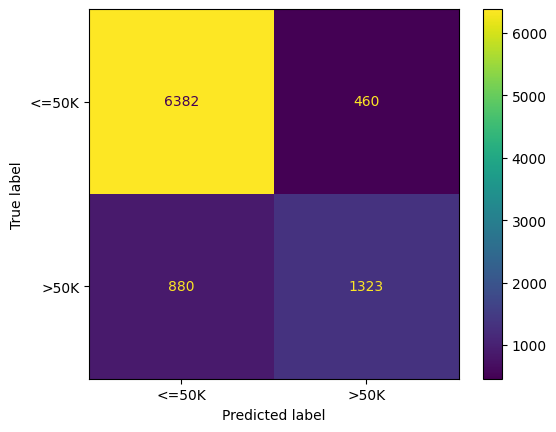

In [41]:
# ─── 5.4 CONFUSION MATRIX ───────────────────────────────
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['<=50K','>50K'])
disp.plot()
plt.show()
# TODO: Identify TP, FP, FN, TN cells

# Step 6: Fairness Check


In [42]:
# # ─── 5.1 EXTRACT GENDER INFO ─────────────────────────────
# # We need the original 'sex' column before one-hot:
# sex = df['gender']
# # .reset_index(drop=True)
# test_sex = sex[X_test.index]
# # TODO: Ensure test_sex aligns with X_test indices
# mask_m = (test_sex == 'Male')
# mask_f = (test_sex == 'Female')

# from sklearn.metrics import accuracy_score
# acc_m = accuracy_score(y_test[mask_m], y_pred[mask_m])
# acc_f = accuracy_score(y_test[mask_f], y_pred[mask_f])

# print(f"Male accuracy:   {acc_m:.3f}")
# print(f"Female accuracy: {acc_f:.3f}")
# # TODO: Discuss why these may differ

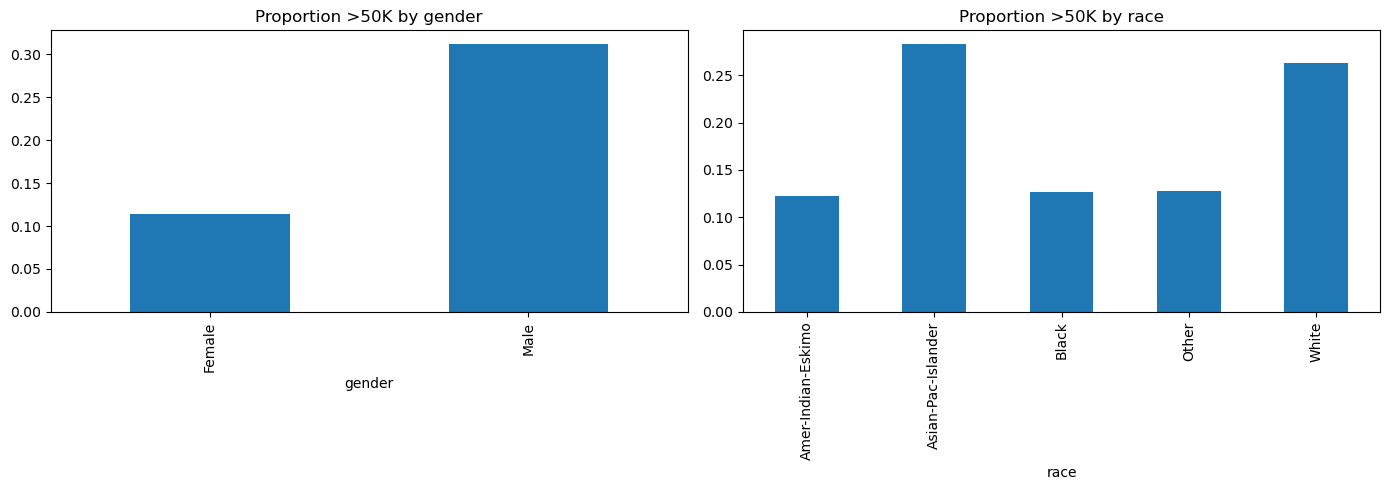

In [31]:
# ─── Define a reusable plotting function ────────────────────────────────
def plot_percentage_by_group(ax, df, col_name, x_label=None, y_label=None):
    """
    Plots the percentage of people with income >50K for each category in `col_name`.
    
    ax        : a matplotlib Axes object
    df        : DataFrame containing 'incomeHigherThan50k' and col_name
    col_name  : the column to group by (e.g. 'sex' or 'race')
    x_label   : optional label for x-axis
    y_label   : optional label for y-axis
    """
    # Total count per group
    group_sizes = df.groupby(col_name).size()
    # Count of >50K per group
    higher_income = df[df['income_higher_than_50k'] == 1].groupby(col_name).size()
    # Compute proportions (fill missing groups with 0)
    percentages = (higher_income / group_sizes).fillna(0)
    
    # Plot as bar chart
    percentages.plot(
        kind='bar',
        ax=ax,
        title=f'Proportion >50K by {col_name}'
    )
    
# ─── Create side-by-side plots for Gender & Race ─────────────────────────
fig, axes = plt.subplots(ncols=2, figsize=(14,5))

plot_percentage_by_group(
    axes[0], df, 'gender',
    x_label='Gender', y_label='Proportion >50K'
)
plot_percentage_by_group(
    axes[1], df, 'race',
    x_label='Race', y_label='Proportion >50K'
)
plt.tight_layout()
plt.show()


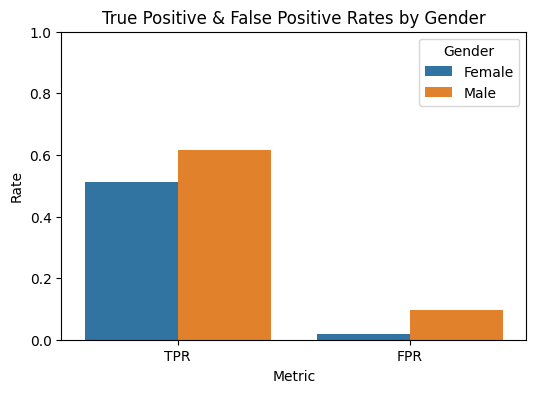

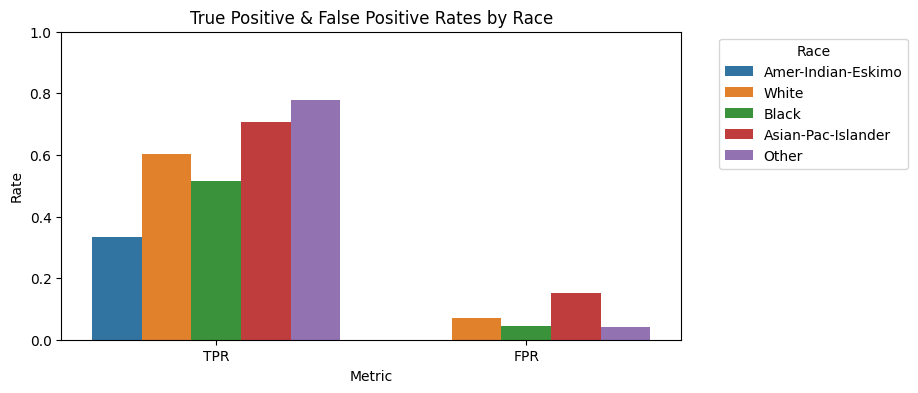

In [52]:
def compute_group_rates(y_true, y_pred, groups):
    records = []
    for g in groups.unique():
        mask = (groups == g)
        tn, fp, fn, tp = confusion_matrix(
            y_true[mask], y_pred[mask], labels=[0,1]
        ).ravel()
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        records.append({'group': g, 'TPR': tpr, 'FPR': fpr})
    return pd.DataFrame(records)

# Recover original sensitive attributes for the test set
gender_test = df.loc[X_test.index, 'gender']          # 'Male' or 'Female'
race_test = df.loc[X_test.index, 'race']        # e.g. 'White', 'Black', etc.

# 1) Get the rates per sensitive group
gender_rates = compute_group_rates(y_test, y_pred, groups=gender_test)
race_rates = compute_group_rates(y_test, y_pred, groups=race_test)    

# Melt data together for gender
gender_long = gender_rates.melt(
    id_vars='group',
    value_vars=['TPR','FPR'],
    var_name='Metric',
    value_name='Rate'
)

# Melt for race
race_long = race_rates.melt(
    id_vars='group',
    value_vars=['TPR','FPR'],
    var_name='Metric',
    value_name='Rate'
)

# 2a) Plot gender metrics
plt.figure(figsize=(6,4))
sns.barplot(
    data=gender_long,
    x='Metric',        # TPR vs FPR
    y='Rate',
    hue='group'        # Male vs Female
)
plt.ylim(0,1)
plt.title('True Positive & False Positive Rates by Gender')
plt.ylabel('Rate')
plt.legend(title='Gender')
plt.show()


# 2b) Plot race metrics
plt.figure(figsize=(8,4))
sns.barplot(
    data=race_long,
    x='Metric',        # TPR vs FPR
    y='Rate',
    hue='group'        # each race category
)
plt.ylim(0,1)
plt.title('True Positive & False Positive Rates by Race')
plt.ylabel('Rate')
plt.legend(title='Race', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [53]:
def evaluate_equalized_odds(rates_df, attr_name):
    """
    Given a DataFrame with columns ['group','TPR','FPR'], compute:
      - max/min TPR & FPR
      - absolute gap (max - min)
      - ratio   (min / max) for four-fifths test
    
    Returns a DataFrame summarizing these metrics for the protected attribute.
    """
    # Extract max/min
    tpr_max, tpr_min = rates_df['TPR'].max(), rates_df['TPR'].min()
    fpr_max, fpr_min = rates_df['FPR'].max(), rates_df['FPR'].min()
    
    # Compute metrics
    summary = {
        'Attribute': attr_name,
        # 'TPR_max': tpr_max,
        # 'TPR_min': tpr_min,
        'TPR_gap': tpr_max - tpr_min,
        'TPR_ratio': (tpr_min / tpr_max) if tpr_max>0 else float('nan'),
        # 'FPR_max': fpr_max,
        # 'FPR_min': fpr_min,
        'FPR_gap': fpr_max - fpr_min,
        'FPR_ratio': (fpr_min / fpr_max) if fpr_max>0 else float('nan'),
    }
    return pd.DataFrame([summary])

gender_summary = evaluate_equalized_odds(gender_rates, "Gender")
race_summary   = evaluate_equalized_odds(race_rates,   "Race")

# Combine and display
fairness_summary = pd.concat([gender_summary, race_summary], ignore_index=True)
fairness_summary.style.format({
    'TPR_max':'{:.2f}', 'TPR_min':'{:.2f}', 'TPR_gap':'{:.2f}', 'TPR_ratio':'{:.2f}',
    'FPR_max':'{:.2f}', 'FPR_min':'{:.2f}', 'FPR_gap':'{:.2f}', 'FPR_ratio':'{:.2f}',
})

,Attribute,TPR_gap,TPR_ratio,FPR_gap,FPR_ratio
0,Gender,0.10,0.83,0.08,0.19
1,Race,0.44,0.43,0.15,0.00


# Step 7: Introduce fairlearn library

In [46]:
from fairlearn.reductions import ExponentiatedGradient, EqualizedOdds
from fairlearn.metrics import MetricFrame, true_positive_rate, false_positive_rate

# Prepare Sensitive Features DataFrames
# Extract **gender** for your train/test splits so Fairlearn can enforce fairness across this feature.

# 1) isolate just gender
gender_train = df.loc[X_train.index, 'gender']
gender_test  = df.loc[X_test.index,  'gender']

# Quick preview
print("Training sensitive features:\n", gender_train.head())
print("\nTest sensitive features:\n",  gender_test.head())

Training sensitive features:
 8605       Male
28547    Female
33927    Female
14437      Male
41839      Male
Name: gender, dtype: object

Test sensitive features:
 21762    Female
21701      Male
42663      Male
42694      Male
13590      Male
Name: gender, dtype: object



### Now we train a Fairness‐Aware Model
By wrapping a `LogisticRegression` in `ExponentiatedGradient` to enforce Equalized Odds.


In [57]:
# 2) define base estimator
base_est = model # The model we trained earlier
from sklearn.ensemble import RandomForestClassifier
base_est = RandomForestClassifier(n_estimators=100, random_state=42)

# 3) wrap in ExponentiatedGradient with EqualizedOdds on gender
mitigator = ExponentiatedGradient(
    estimator=base_est,
    constraints=EqualizedOdds(),
    eps=0.01              # defines how much unequal treatment you're willing to accept across protected groups
)

# 4) fit on training data + gender
mitigator.fit(
    X_train,
    y_train,
    sensitive_features=gender_train
)

ExponentiatedGradient(constraints=<fairlearn.reductions._moments.utility_parity.EqualizedOdds object at 0x14b4978c0>,
                      estimator=RandomForestClassifier(random_state=42),
                      nu=2.3937901545969885e-05)

### Evaluate new improved model
Check overall accuracy, classification report, then confirm TPR/FPR parity across gender.

In [58]:
# 5) predict & evaluate
y_pred_fair = mitigator.predict(X_test)
print("Fair (gender-only) model accuracy:", accuracy_score(y_test, y_pred_fair))
print(classification_report(y_test, y_pred_fair))

# 6) compute TPR & FPR by gender
metric_frame = MetricFrame(
    metrics={'TPR': true_positive_rate, 'FPR': false_positive_rate},
    y_true=y_test,
    y_pred=y_pred_fair,
    sensitive_features=gender_test
)
print("\nEqualized Odds metrics by gender:")
print(metric_frame.by_group)

Fair (gender-only) model accuracy: 0.8527363184079602
              precision    recall  f1-score   support

           0       0.88      0.93      0.90      6842
           1       0.73      0.62      0.67      2203

    accuracy                           0.85      9045
   macro avg       0.81      0.78      0.79      9045
weighted avg       0.85      0.85      0.85      9045


Equalized Odds metrics by gender:
             TPR       FPR
gender                    
Female  0.546547  0.025869
Male    0.637968  0.102775


### Visualize TPR & FPR
Plot side‐by‐side bar charts to confirm the disparities have been reduced.


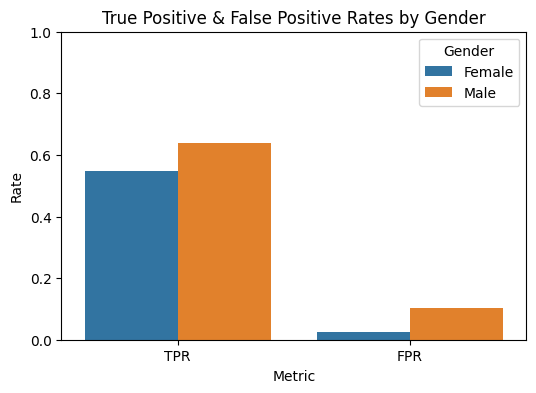

,attr,TPR,FPR
0,Gap,0.102529,0.078363
1,Ratio,0.833568,0.191266


In [59]:
# 7) plot gender bars
gender_long = metric_frame.by_group.reset_index().melt(
    id_vars='gender',
    value_vars=['TPR','FPR'],
    var_name='Metric',
    value_name='Rate'
)

plt.figure(figsize=(6,4))
sns.barplot(
    data=gender_long,
    x='Metric',
    y='Rate',
    hue='gender',
    errorbar=None
)
plt.ylim(0,1)
plt.title("True Positive & False Positive Rates by Gender")
plt.ylabel("Rate")
plt.legend(title='Gender')
plt.show()


# Assuming `gender_summary` is your 1-row DataFrame from evaluate_equalized_odds
summary_table = pd.DataFrame({
    'attr': ['Gap', 'Ratio'],
    'TPR': [gender_summary.at[0, 'TPR_gap'],
            gender_summary.at[0, 'TPR_ratio']],
    'FPR': [gender_summary.at[0, 'FPR_gap'],
            gender_summary.at[0, 'FPR_ratio']]
})

# Display it nicely in Jupyter
summary_table.style.set_table_styles([
    {'selector': 'thx', 'props': [('text-align', 'center')]},
    {'selector': 'td', 'props': [('text-align', 'center')]}
])


# %% [markdown]
# ### Step 6: Save Your Production‐Ready Model
# 
# Serialize the fairness‐aware model for deployment, just like any other sklearn estimator.
# ```
# joblib.dump(mitigator, 'fair_prod_model_multigroup.joblib')
# print("✅ Model saved → fair_prod_model_multigroup.joblib")
# ```



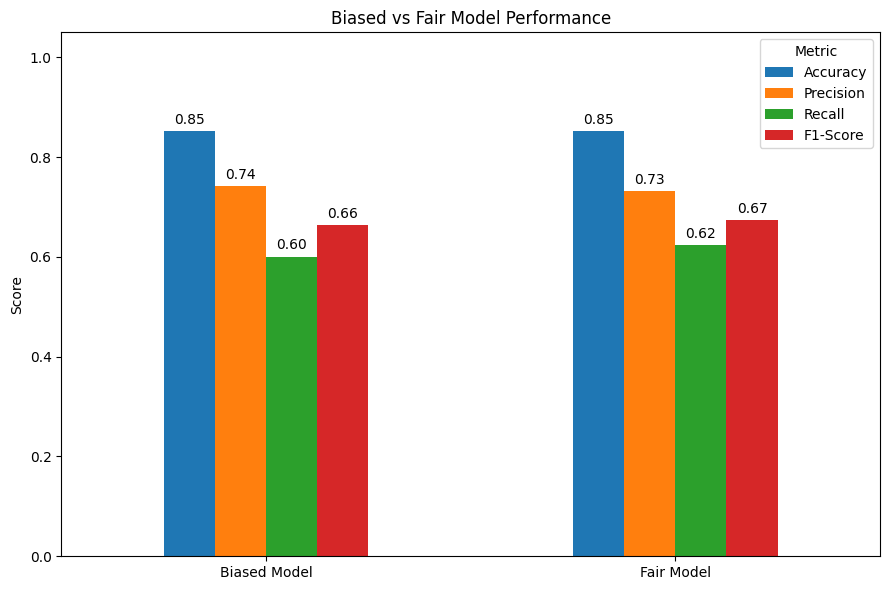

In [60]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate metrics
metrics = {
    "Accuracy": accuracy_score,
    "Precision": lambda y_true, y_pred: precision_score(y_true, y_pred, zero_division=0),
    "Recall": lambda y_true, y_pred: recall_score(y_true, y_pred, zero_division=0),
    "F1-Score": lambda y_true, y_pred: f1_score(y_true, y_pred, zero_division=0)
}

# Compute values
scores = {
    "Biased Model": [],
    "Fair Model": []
}

for _, func in metrics.items():
    scores["Biased Model"].append(func(y_test, y_pred))
    scores["Fair Model"].append(func(y_test, y_pred_fair))

# Create DataFrame
score_df = pd.DataFrame(scores, index=metrics.keys()).T

# Plot
ax = score_df.plot(kind='bar', figsize=(9,6), ylim=(0,1.05))
plt.title("Biased vs Fair Model Performance")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(title="Metric", loc='upper right')

# Add value labels on each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge', padding=3)

plt.tight_layout()
plt.show()
